In [6]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from build_lenet import LeNet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2
import os

In [7]:
# initialize the list of data and labels
data = []
labels = []

arg = {"dataset" : "SMILEsmileD/", "model" : "./model/", "plot" : "./plot/plot_image.png"}

In [8]:

# loop over the input images
for imagePath in sorted(list(paths.list_images(arg["dataset"]))):
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	image = imutils.resize(image, width=28)
	image = img_to_array(image)
	data.append(image)
	# extract the class label from the image path and update the
	# labels list
	label = imagePath.split(os.path.sep)[-3]
	label = "smiling" if label == "positives" else "not_smiling"
	labels.append(label)
	#print(label)
	#np.append(labels, label)

In [12]:
print(len(labels))

13165


In [13]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
# convert the labels from integers to vectors
le = LabelEncoder().fit(labels)
labels = to_categorical(le.transform(labels), 2)

In [14]:
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [15]:
# calculate the total number of training images in each class and
# initialize a dictionary to store the class weights
classTotals = labels.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

In [16]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, stratify=labels, random_state=42)

#LeNet

In [17]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width = 28, height = 28, depth = 1, classes = 2)
model.compile(loss = "binary_crossentropy", optimizer = "adam",
    metrics = ["accuracy"])

# train the network
print("[INFO] training network...")
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modify the model.fit to include the early stopping callback - avoid overfitting
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              class_weight=classWeight, batch_size=64, epochs=15,
              verbose=1, callbacks=[early_stopping])

#H = model.fit(trainX, trainY, validation_data = (testX, testY),
 #   class_weight = classWeight, batch_size = 64, epochs = 15, verbose = 1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/15
165/165 [==============================] - 12s 66ms/step - loss: 0.6577 - accuracy: 0.7674 - val_loss: 0.2943 - val_accuracy: 0.8712
Epoch 2/15
165/165 [==============================] - 9s 55ms/step - loss: 0.4674 - accuracy: 0.8642 - val_loss: 0.3019 - val_accuracy: 0.8709
Epoch 3/15
165/165 [==============================] - 9s 52ms/step - loss: 0.4126 - accuracy: 0.8833 - val_loss: 0.3693 - val_accuracy: 0.8390
Epoch 4/15
165/165 [==============================] - 9s 53ms/step - loss: 0.3855 - accuracy: 0.8967 - val_loss: 0.4116 - val_accuracy: 0.8226
Epoch 5/15
165/165 [==============================] - 9s 52ms/step - loss: 0.3663 - accuracy: 0.8991 - val_loss: 0.2684 - val_accuracy: 0.9020
Epoch 6/15
165/165 [==============================] - 9s 52ms/step - loss: 0.3517 - accuracy: 0.9033 - val_loss: 0.2523 - val_accuracy: 0.9005
Epoch 7/15
165/165 [==============================] - 9s 52ms/step - loss: 0.3406 - accu

In [18]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size = 64)
print(classification_report(testY.argmax(axis = 1),
    predictions.argmax(axis = 1), target_names = le.classes_))

# save the model to disk
model.save(arg["model"])

[INFO] evaluating network...
42/42 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

 not_smiling       0.93      0.94      0.94      1895
     smiling       0.84      0.83      0.83       738

    accuracy                           0.91      2633
   macro avg       0.89      0.88      0.88      2633
weighted avg       0.91      0.91      0.91      2633



INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


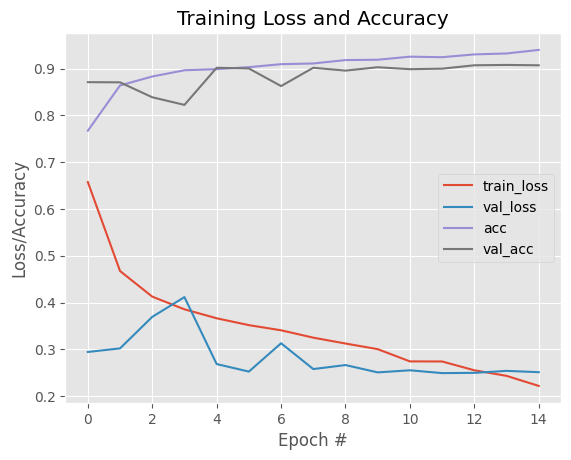

In [22]:
# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, 15), H.history["accuracy"], label = "acc")
plt.plot(np.arange(0, 15), H.history["val_accuracy"], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(arg["plot"])
plt.show()